# Flying Solo

Let's create an MNIST classifier. Heavily based on [this code](https://github.com/amitrajitbose/handwritten-digit-recognition).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from time import time
from tqdm.notebook import tqdm
import torch


First, we need to prepare the data.

In [2]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Download and load the training data
trainset_original = datasets.MNIST('cache/mnist/', download=True, train=True, transform=None)
valset_original   = datasets.MNIST('cache/mnist/', download=True, train=False, transform=None)
trainset = datasets.MNIST('cache/mnist/', download=True, train=True, transform=transform)
valset   = datasets.MNIST('cache/mnist/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader   = torch.utils.data.DataLoader(valset, shuffle=True) # no batches for validation

In [120]:
valset_original[1][0]

Now, let's create a general function for training a model.

In [3]:
# NN creation
from torch import nn
from torch import optim

def create_and_train():
    # Layer details for the neural network
    input_size = 784
    hidden_sizes = [128, 64]
    output_size = 10

    # Build a feed-forward network
    model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[1], output_size),
                          nn.LogSoftmax(dim=1))
    print(model)


    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    optimizer.zero_grad()
    criterion = nn.NLLLoss()
    time0 = time()
    epochs = 15
    for e in tqdm(range(epochs)):
        running_loss = 0
        for images, labels in tqdm(trainloader):
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            # Training pass
            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            #This is where the model learns by backpropagating
            loss.backward()

            #And optimizes its weights here
            optimizer.step()

            running_loss += loss.item()
        
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    
    return model

In [4]:
model = create_and_train()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 0 - Training loss: 0.6271406713007356


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 - Training loss: 0.2865193712511169


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 - Training loss: 0.22409184431152812


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 - Training loss: 0.18164734904175756


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 - Training loss: 0.15035854541718452


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 - Training loss: 0.1292851524445405


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6 - Training loss: 0.1127979558801203


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7 - Training loss: 0.1007665702805066


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8 - Training loss: 0.09083427725308167


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9 - Training loss: 0.08206176233968374


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10 - Training loss: 0.07426235104438418


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11 - Training loss: 0.06859673187732379


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12 - Training loss: 0.06080101685934086


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13 - Training loss: 0.05708044767727269


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14 - Training loss: 0.052268598430744335

Training Time (in minutes) = 2.4207160313924154


In [5]:
correct_count, all_count = 0, 0
for images, labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
        correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9724


## Evaluation with LIME

Ok, here's where the magic happens. We're going to figure out which parts of the image are important for finding a class label. This code is based on [the LIME docs](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb).

In [100]:
import torch.nn.functional as F
from PIL import Image

def batch_predict(images):
    # set model to evaluation mode
    model.eval()

    
    # stack together a bunch of images together
#    batch = torch.stack(images, dim=0)

    # Ignoring this from
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model.to(device)
    #batch = batch.to(device)
    
    # doing this the Correct Way(tm) didn't work, so uh
    # we're just gonna make this the wrong way
    outputs = []
    for img in images:
        #print(img)
        if type(img) != Image.Image:
            img_pil = Image.fromarray(img)
            if img_pil.mode != 'L':
                img_pil = img_pil.convert(mode='L')
        else:
            img_pil = img
        #print(img_pil)
        with torch.no_grad():
            logps = model(transform(img_pil).view(1,784))
        ps = torch.exp(logps)
        ps = F.softmax(ps, dim=1)
        outputs.append(ps.detach().cpu().numpy())
    
    return np.vstack(outputs)

In [101]:
batch_predict([valset_original[0][0], valset_original[1][0]])

array([[0.08534339, 0.08534329, 0.08534592, 0.08538111, 0.08534328,
        0.08534328, 0.08534328, 0.23186588, 0.08534397, 0.08534659],
       [0.0853394 , 0.08534839, 0.23192911, 0.08534053, 0.08533928,
        0.08533929, 0.08533943, 0.08533928, 0.08534598, 0.08533928]],
      dtype=float32)

In [9]:
#def convert_img_from_nn(mtx):
#    

In [124]:
%%time

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

explainer = lime_image.LimeImageExplainer(verbose=True)
explanation = explainer.explain_instance(
    np.array(valset_original[0][0]),
    classifier_fn=batch_predict, # classification function
    labels=[0,1,2,3,4,5,6,7,8,9],
#    valset_original[0][1],
    top_labels=10,
#    hide_color=1,
    num_samples=10000,  # number of images that will be sent to classification function
    segmentation_fn=segmenter
)



  0%|          | 0/10000 [00:00<?, ?it/s]

Intercept 0.0923533052023957
Prediction_local [0.0856946]
Right: 0.08534328
Intercept 0.1372132084977599
Prediction_local [0.07301673]
Right: 0.08534328
Intercept 0.08851095726496623
Prediction_local [0.08532157]
Right: 0.08534328
Intercept 0.08890421718598511
Prediction_local [0.08522314]
Right: 0.08534329
Intercept 0.08874403773579209
Prediction_local [0.08528592]
Right: 0.08534339
Intercept 0.0892775154446746
Prediction_local [0.0851941]
Right: 0.08534397
Intercept 0.08915882766421626
Prediction_local [0.08527145]
Right: 0.08534592
Intercept 0.12879099585838302
Prediction_local [0.0966993]
Right: 0.08534659
Intercept 0.08973781090613187
Prediction_local [0.08522464]
Right: 0.085381106
Intercept 0.10730918434635232
Prediction_local [0.23306855]
Right: 0.23186588
CPU times: user 3.6 s, sys: 90.2 ms, total: 3.69 s
Wall time: 3.56 s


Text(0.5, 1.0, 'Positive/Negative Regions for 7')

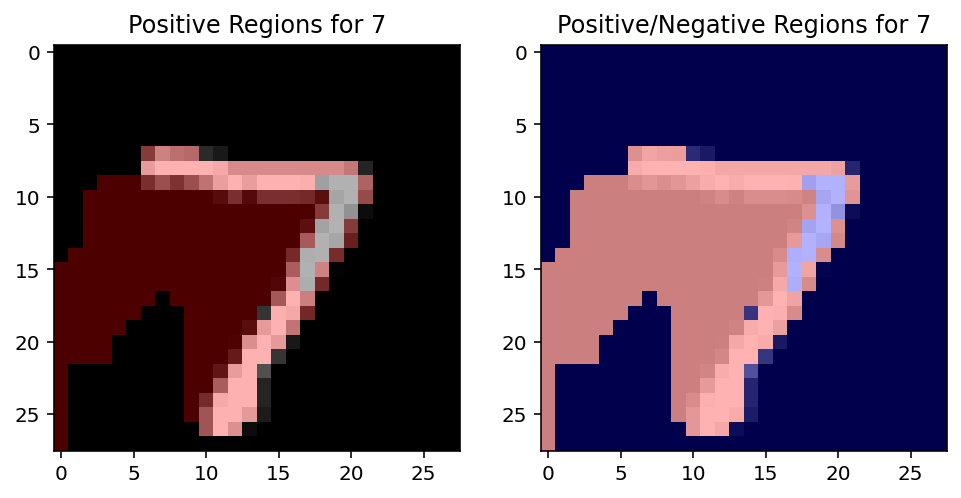

In [128]:
#from skimage.color import gray2rgb, rgb2gray, label2rgb
from skimage.color import gray2rgb, rgb2gray, label2rgb

temp, mask = explanation.get_image_and_mask(valset_original[0][1], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(valset_original[0][1]))
temp, mask = explanation.get_image_and_mask(valset_original[0][1], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(valset_original[0][1]))

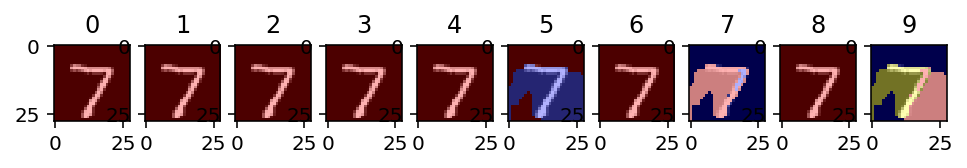

In [133]:
fig, axs = plt.subplots(1,10, figsize = (8, 4))

for i in range(len(axs)):
    ax = axs[i]
    temp, mask = explanation.get_image_and_mask(i, positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
    ax.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
    ax.set_title('{}'.format(i))

In [132]:
def showall():

{4: [(3, -0.0073761745246353795),
  (4, 0.000908253083196524),
  (0, -0.00016384482672044803),
  (5, -2.7305671952672632e-05),
  (2, 4.999014032026997e-06),
  (1, -4.627952057147225e-06)],
 5: [(3, -0.03373311499664829),
  (4, -0.031128206636126754),
  (5, 0.0007448364390560696),
  (1, 0.00017596694172707477),
  (2, -0.000132416411092914),
  (0, -0.0001235434940384148)],
 6: [(3, -0.0029899214268754738),
  (4, -0.000200338845368963),
  (5, 9.553278826377738e-07),
  (1, 2.5447663296250503e-07),
  (0, -2.5102379017380657e-07),
  (2, -8.781355430709359e-08)],
 1: [(3, -0.0032364766438796404),
  (4, -0.00044672711270305414),
  (5, 6.973602195098446e-06),
  (0, -5.478347011550353e-06),
  (1, 1.7349349041338165e-06),
  (2, -1.1063550566594348e-06)],
 0: [(3, -0.003169555930247788),
  (4, -0.00029211760987238783),
  (5, 3.006915231625343e-06),
  (1, 7.196014044442646e-07),
  (2, -4.847746609977791e-07),
  (0, 3.0981422454054187e-07)],
 8: [(3, -0.00356661689185709),
  (4, -0.00054623660786951